In [812]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import os

In [813]:
df = pd.read_csv('data.csv')
df.head()

,age,height_cm,weight_kgs,nationality,overall_rating,preferred_foot,weak_foot(1-5),skill_moves(1-5),crossing,finishing,...,positions_GK,positions_LB,positions_LM,positions_LW,positions_LWB,positions_RB,positions_RM,positions_RW,positions_RWB,positions_ST
0,27,177.606642,76.2,Denmark,88,1,5,4,88,81,...,0,0,0,0,0,0,1,0,0,0
1,25,190.500000,83.9,France,88,1,4,5,80,75,...,0,0,0,0,0,0,0,0,0,0
2,27,162.560000,59.0,Italy,88,1,4,4,86,77,...,0,0,0,1,0,0,0,0,0,1
3,27,187.960000,88.9,Senegal,88,1,3,2,30,22,...,0,0,0,0,0,0,0,0,0,0
4,27,193.040000,92.1,Netherlands,88,1,3,2,53,52,...,0,0,0,0,0,0,0,0,0,0


In [814]:
X = df.drop('overall_rating', axis=1)
y = df['overall_rating']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [815]:
print('Train shape:', X_train.shape)
print('Validation shape:', X_val.shape)
print('Test shape:', X_test.shape)

Train shape: (11305, 52)
Validation shape: (1257, 52)
Test shape: (5385, 52)


### Pipeline to preprocess dataset

In [816]:
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler

preprocessor = Pipeline([
    ('target_encoder', TargetEncoder(cols=['nationality'])),
    ('scaler', StandardScaler())
])

In [817]:
X_train = preprocessor.fit_transform(X_train, y_train)
X_val = preprocessor.transform(X_val)

In [818]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

### Function to train model

In [819]:
def train_model(model, optimizer, criterion, X_train_tensor, y_train_tensor, 
               X_val_tensor, y_val_tensor, epochs, t='Validation'):
    train_losses = []
    val_losses = []
    r2_trains = []
    r2_vals = []

    for epoch in range(epochs + 1):
        model.train()
        optimizer.zero_grad()

        y_train_pred = model(X_train_tensor).squeeze()
        y_train_true = y_train_tensor.squeeze()

        train_loss = criterion(y_train_pred, y_train_true)

        train_loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            model.eval()
            
            with torch.no_grad():
                train_losses.append(train_loss.item())

                y_val_pred = model(X_val_tensor).squeeze()
                y_val_true = y_val_tensor.squeeze()

                val_loss = criterion(y_val_pred, y_val_true)
                val_losses.append(val_loss.item())

                r2_train = r2_score(y_train_true.cpu().numpy(), y_train_pred.cpu().numpy())
                r2_val = r2_score(y_val_true.cpu().numpy(), y_val_pred.cpu().numpy())
                r2_trains.append(r2_train)
                r2_vals.append(r2_val)

            print(f'\nEpoch [{epoch}/{epochs}]:\tTrain Loss: {train_loss.item():.3f}\tTrain R2: {r2_train:.3f}\t{t} Loss: {val_loss.item():.3f}\t{t} R2: {r2_val:.3f}')

    return train_losses, val_losses, r2_trains, r2_vals


### Evaluation Function

In [820]:
import torch
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def evaluate_model(model, criterion, X_train_tensor, y_train_tensor, 
                  X_val_tensor, y_val_tensor, device='cpu', 
                  print_metrics=True, is_val=True):
    X_train_tensor = X_train_tensor.to(device)
    y_train_tensor = y_train_tensor.to(device).squeeze()  # Squeeze target
    X_val_tensor = X_val_tensor.to(device)
    y_val_tensor = y_val_tensor.to(device).squeeze()      # Squeeze target
    model = model.to(device)

    # Set model to evaluation mode
    model.eval()
    
    with torch.no_grad():
        y_train_pred = model(X_train_tensor).squeeze()  # Squeeze predictions if necessary
        y_val_pred = model(X_val_tensor).squeeze()
        
        train_loss = criterion(y_train_pred, y_train_tensor).item()
        val_loss = criterion(y_val_pred, y_val_tensor).item()

        # Move tensors to CPU and convert to NumPy for metric calculations
        y_train_np = y_train_tensor.cpu().numpy()
        y_val_np = y_val_tensor.cpu().numpy()
        y_train_pred_np = y_train_pred.cpu().numpy()
        y_val_pred_np = y_val_pred.cpu().numpy()

        mse_train = mean_squared_error(y_train_np, y_train_pred_np)
        mse_val = mean_squared_error(y_val_np, y_val_pred_np)

        mae_train = mean_absolute_error(y_train_np, y_train_pred_np)
        mae_val = mean_absolute_error(y_val_np, y_val_pred_np)

        r2_train = r2_score(y_train_np, y_train_pred_np)
        r2_val = r2_score(y_val_np, y_val_pred_np)

    t = 'Validation' if is_val else 'Test'

    metrics = {
        'train': {
            'MSE': mse_train,
            'MAE': mae_train,
            'R2': r2_train
        },
        t: {
            'MSE': mse_val,
            'MAE': mae_val,
            'R2': r2_val
        }
    }

    if print_metrics:
        print('Train Set:')
        print(f"MSE: {metrics['train']['MSE']:.3f}")
        print(f"MAE: {metrics['train']['MAE']:.3f}")
        print(f"R2: {metrics['train']['R2']:.3f}\n")

        print(f'{t} Set:')
        print(f"MSE: {metrics[t]['MSE']:.3f}")
        print(f"MAE: {metrics[t]['MAE']:.3f}")
        print(f"R2: {metrics[t]['R2']:.3f}")

    return metrics


## 1HL

In [866]:
class CustomMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CustomMLP, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.Sigmoid(),
            nn.BatchNorm1d(32)
        )
        self.layer2 = nn.Linear(32, output_dim)
        # self.initialize_weights()

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return x
    
    # def initialize_weights(self):
    #     for m in self.modules():
    #         if isinstance(m, nn.Linear):
    #             nn.init.xavier_normal_(m.weight)
    #             nn.init.zeros_(m.bias)

In [867]:
model = CustomMLP(input_dim=X_train_tensor.shape[1], output_dim=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [868]:
epochs = 500
train_losses = []
val_losses = []
r2_trains = []
r2_vals = []

In [869]:
train_losses, val_losses, r2_trains, r2_vals = train_model(model, optimizer, criterion, 
                                                        X_train_tensor, y_train_tensor,
                                                        X_val_tensor, y_val_tensor, epochs)


Epoch [0/500]:	Train Loss: 4418.028	Train R2: -90.297	Validation Loss: 4438.705	Validation R2: -91.359

Epoch [10/500]:	Train Loss: 4366.153	Train R2: -89.225	Validation Loss: 4372.113	Validation R2: -89.974

Epoch [20/500]:	Train Loss: 4301.989	Train R2: -87.899	Validation Loss: 4301.615	Validation R2: -88.507

Epoch [30/500]:	Train Loss: 4209.053	Train R2: -85.978	Validation Loss: 4213.775	Validation R2: -86.679

Epoch [40/500]:	Train Loss: 4083.680	Train R2: -83.387	Validation Loss: 4104.812	Validation R2: -84.412

Epoch [50/500]:	Train Loss: 3918.296	Train R2: -79.970	Validation Loss: 3953.377	Validation R2: -81.261

Epoch [60/500]:	Train Loss: 3711.932	Train R2: -75.705	Validation Loss: 3761.159	Validation R2: -77.261

Epoch [70/500]:	Train Loss: 3466.706	Train R2: -70.638	Validation Loss: 3540.692	Validation R2: -72.674

Epoch [80/500]:	Train Loss: 3187.399	Train R2: -64.866	Validation Loss: 3279.080	Validation R2: -67.230

Epoch [90/500]:	Train Loss: 2880.916	Train R2: -58.533	

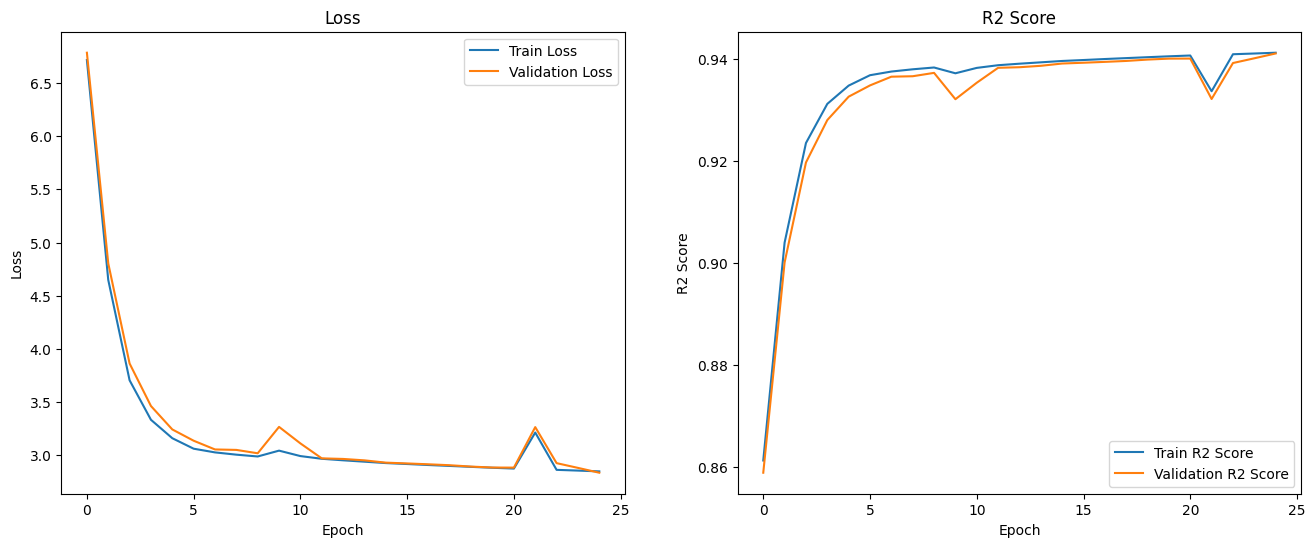

In [870]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(train_losses[-25:], label='Train Loss')
axes[0].plot(val_losses[-25:], label='Validation Loss')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(r2_trains[-25:], label='Train R2 Score')
axes[1].plot(r2_vals[-25:], label='Validation R2 Score')
axes[1].set_title('R2 Score')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('R2 Score')
axes[1].legend()

# output_path = os.path.join('images', '.png')
# plt.savefig(output_path)
# print(f'Image saved at {output_path}')

plt.show()

In [871]:
metrics = evaluate_model(model, criterion, 
                        X_train_tensor, y_train_tensor, 
                        X_val_tensor, y_val_tensor)

Train Set:
MSE: 2.854
MAE: 0.953
R2: 0.941

Validation Set:
MSE: 2.835
MAE: 0.930
R2: 0.941


In [872]:
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = preprocessor.fit_transform(X_train, y_train)
X_test = preprocessor.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [873]:
model = CustomMLP(input_dim=X_train_tensor.shape[1], output_dim=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [874]:
train_losses, test_losses, r2_trains, r2_tests = train_model(model, optimizer, criterion, 
                                                        X_train_tensor, y_train_tensor,
                                                        X_test_tensor, y_test_tensor, epochs,
                                                        t='Test')


Epoch [0/500]:	Train Loss: 4457.626	Train R2: -91.115	Test Loss: 4412.120	Test R2: -90.666

Epoch [10/500]:	Train Loss: 4403.562	Train R2: -89.998	Test Loss: 4373.121	Test R2: -89.856

Epoch [20/500]:	Train Loss: 4340.713	Train R2: -88.699	Test Loss: 4318.252	Test R2: -88.716

Epoch [30/500]:	Train Loss: 4248.098	Train R2: -86.785	Test Loss: 4234.403	Test R2: -86.974

Epoch [40/500]:	Train Loss: 4122.565	Train R2: -84.191	Test Loss: 4128.905	Test R2: -84.782

Epoch [50/500]:	Train Loss: 3956.884	Train R2: -80.767	Test Loss: 3982.049	Test R2: -81.731

Epoch [60/500]:	Train Loss: 3749.690	Train R2: -76.486	Test Loss: 3787.327	Test R2: -77.685

Epoch [70/500]:	Train Loss: 3503.244	Train R2: -71.393	Test Loss: 3558.305	Test R2: -72.927

Epoch [80/500]:	Train Loss: 3222.163	Train R2: -65.585	Test Loss: 3290.323	Test R2: -67.360

Epoch [90/500]:	Train Loss: 2913.432	Train R2: -59.205	Test Loss: 2990.894	Test R2: -61.139

Epoch [100/500]:	Train Loss: 2585.540	Train R2: -52.429	Test Loss: 265

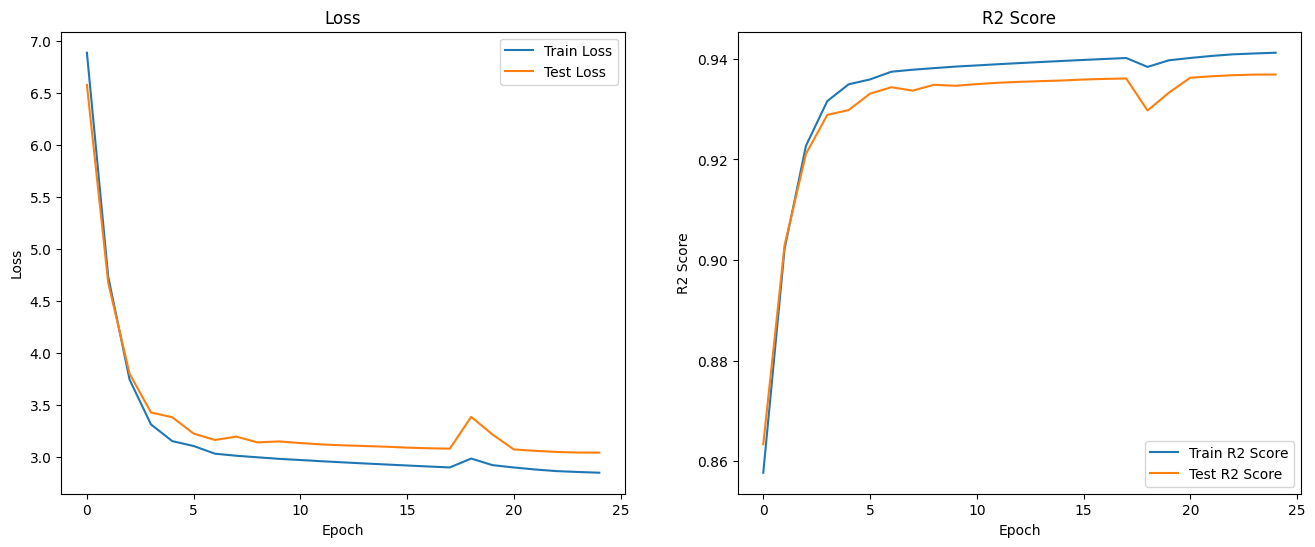

In [875]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(train_losses[-25:], label='Train Loss')
axes[0].plot(test_losses[-25:], label='Test Loss')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(r2_trains[-25:], label='Train R2 Score')
axes[1].plot(r2_tests[-25:], label='Test R2 Score')
axes[1].set_title('R2 Score')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('R2 Score')
axes[1].legend()

# output_path = os.path.join('images', '.png')
# plt.savefig(output_path)
# print(f'Image saved at {output_path}')

plt.show()

In [876]:
metrics = evaluate_model(model, criterion,
                        X_train_tensor, y_train_tensor,
                        X_test_tensor, y_test_tensor,
                        is_val=False)

Train Set:
MSE: 2.847
MAE: 0.953
R2: 0.941

Test Set:
MSE: 3.038
MAE: 1.008
R2: 0.937


## 2HL

In [877]:
class CustomMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CustomMLP, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.Sigmoid(),
            nn.BatchNorm1d(32),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(32, 32),
            nn.Sigmoid(),
            nn.BatchNorm1d(32),
        )
        self.layer3 = nn.Linear(32, output_dim)
        # self.initialize_weights()
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x
    
    # def initialize_weights(self):
    #     for m in self.modules():
    #         if isinstance(m, nn.Linear):
    #             nn.init.xavier_normal_(m.weight)
    #             nn.init.zeros_(m.bias)

In [878]:
model = CustomMLP(input_dim=X_train_tensor.shape[1], output_dim=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [879]:
# import torchsummary
# torchsummary.summary(model, (52,))

In [880]:
epochs = 500
train_losses = []
val_losses = []
r2_trains = []
r2_vals = []

In [881]:
train_losses, val_losses, r2_trains, r2_vals = train_model(model, optimizer, criterion,
                                                        X_train_tensor, y_train_tensor,
                                                        X_val_tensor, y_val_tensor, epochs)


Epoch [0/500]:	Train Loss: 4433.456	Train R2: -90.615	Validation Loss: 4464.061	Validation R2: -91.887

Epoch [10/500]:	Train Loss: 4374.620	Train R2: -89.400	Validation Loss: 4406.286	Validation R2: -90.685

Epoch [20/500]:	Train Loss: 4308.516	Train R2: -88.034	Validation Loss: 4357.056	Validation R2: -89.660

Epoch [30/500]:	Train Loss: 4221.084	Train R2: -86.227	Validation Loss: 4256.035	Validation R2: -87.558

Epoch [40/500]:	Train Loss: 4095.482	Train R2: -83.631	Validation Loss: 4174.091	Validation R2: -85.853

Epoch [50/500]:	Train Loss: 3929.357	Train R2: -80.198	Validation Loss: 4132.819	Validation R2: -84.995

Epoch [60/500]:	Train Loss: 3723.030	Train R2: -75.935	Validation Loss: 3970.330	Validation R2: -81.614

Epoch [70/500]:	Train Loss: 3477.549	Train R2: -70.862	Validation Loss: 3666.136	Validation R2: -75.284

Epoch [80/500]:	Train Loss: 3198.463	Train R2: -65.095	Validation Loss: 3404.763	Validation R2: -69.845

Epoch [90/500]:	Train Loss: 2891.255	Train R2: -58.746	

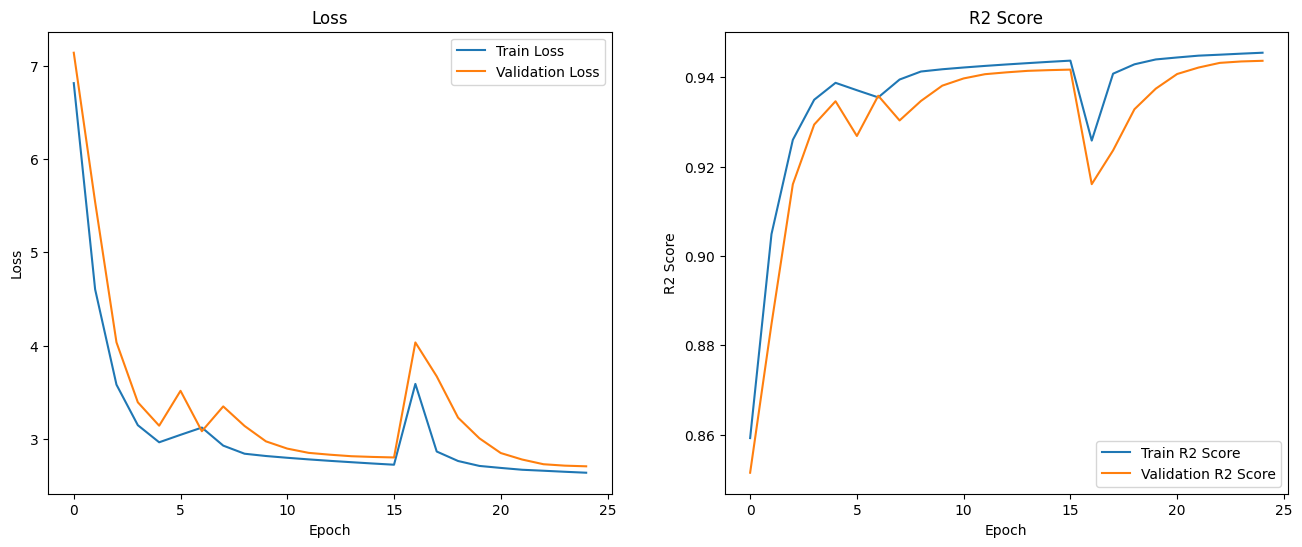

In [882]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(train_losses[-25:], label='Train Loss')
axes[0].plot(val_losses[-25:], label='Validation Loss')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(r2_trains[-25:], label='Train R2 Score')
axes[1].plot(r2_vals[-25:], label='Validation R2 Score')
axes[1].set_title('R2 Score')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('R2 Score')
axes[1].legend()

# output_path = os.path.join('images', '.png')
# plt.savefig(output_path)
# print(f'Image saved at {output_path}')

plt.show()

In [883]:
metrics = evaluate_model(model, criterion, 
                        X_train_tensor, y_train_tensor, 
                        X_val_tensor, y_val_tensor)

Train Set:
MSE: 2.711
MAE: 0.946
R2: 0.944

Validation Set:
MSE: 2.707
MAE: 0.936
R2: 0.944


In [884]:
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = preprocessor.fit_transform(X_train, y_train)
X_test = preprocessor.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [885]:
model = CustomMLP(input_dim=X_train_tensor.shape[1], output_dim=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [886]:
train_losses, test_losses, r2_trains, r2_tests = train_model(model, optimizer, criterion, 
                                                        X_train_tensor, y_train_tensor,
                                                        X_test_tensor, y_test_tensor, epochs,
                                                        t='Test')


Epoch [0/500]:	Train Loss: 4436.307	Train R2: -90.674	Test Loss: 4406.233	Test R2: -90.544

Epoch [10/500]:	Train Loss: 4381.848	Train R2: -89.549	Test Loss: 4354.488	Test R2: -89.469

Epoch [20/500]:	Train Loss: 4317.030	Train R2: -88.210	Test Loss: 4288.136	Test R2: -88.090

Epoch [30/500]:	Train Loss: 4230.585	Train R2: -86.423	Test Loss: 4202.720	Test R2: -86.316

Epoch [40/500]:	Train Loss: 4106.364	Train R2: -83.856	Test Loss: 4184.970	Test R2: -85.947

Epoch [50/500]:	Train Loss: 3941.119	Train R2: -80.441	Test Loss: 4224.462	Test R2: -86.767

Epoch [60/500]:	Train Loss: 3735.795	Train R2: -76.199	Test Loss: 4007.568	Test R2: -82.261

Epoch [70/500]:	Train Loss: 3491.236	Train R2: -71.145	Test Loss: 3631.476	Test R2: -74.447

Epoch [80/500]:	Train Loss: 3212.378	Train R2: -65.382	Test Loss: 3297.806	Test R2: -67.515

Epoch [90/500]:	Train Loss: 2905.414	Train R2: -59.039	Test Loss: 3019.418	Test R2: -61.731

Epoch [100/500]:	Train Loss: 2579.261	Train R2: -52.299	Test Loss: 267

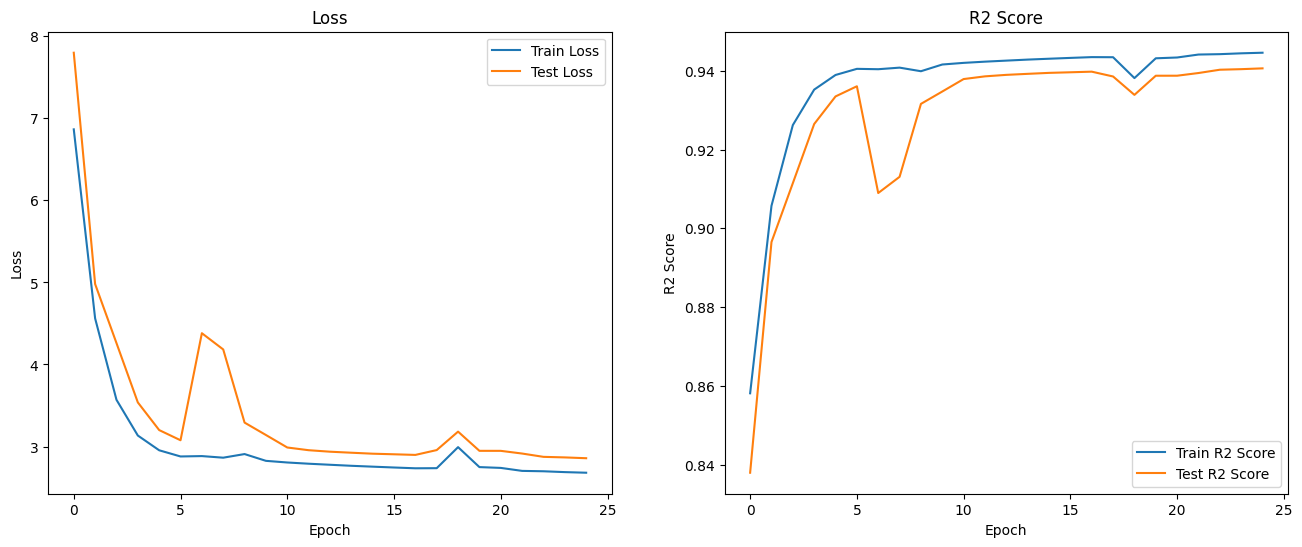

In [887]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(train_losses[-25:], label='Train Loss')
axes[0].plot(test_losses[-25:], label='Test Loss')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(r2_trains[-25:], label='Train R2 Score')
axes[1].plot(r2_tests[-25:], label='Test R2 Score')
axes[1].set_title('R2 Score')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('R2 Score')
axes[1].legend()

# output_path = os.path.join('images', '.png')
# plt.savefig(output_path)
# print(f'Image saved at {output_path}')

plt.show()

In [888]:
metrics = evaluate_model(model, criterion,
                        X_train_tensor, y_train_tensor,
                        X_test_tensor, y_test_tensor,
                        is_val=False)

Train Set:
MSE: 2.688
MAE: 0.915
R2: 0.944

Test Set:
MSE: 2.858
MAE: 0.967
R2: 0.941


## 3HL

In [855]:
class CustomMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CustomMLP, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.Sigmoid(),
            nn.BatchNorm1d(32),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(32, 32),
            nn.Sigmoid(),
            nn.BatchNorm1d(32),
        )
        self.layer3 = nn.Sequential(
            nn.Linear(32, 32),
            nn.Sigmoid(),
            nn.BatchNorm1d(32),
        )
        self.layer4 = nn.Linear(32, output_dim)
        # self.initialize_weights()
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x
    
    # def initialize_weights(self):
    #     for m in self.modules():
    #         if isinstance(m, nn.Linear):
    #             nn.init.xavier_normal_(m.weight)
    #             nn.init.zeros_(m.bias)

In [856]:
model = CustomMLP(input_dim=X_train_tensor.shape[1], output_dim=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [857]:
epochs = 500
train_losses = []
val_losses = []
r2_trains = []
r2_vals = []

In [858]:
train_losses, val_losses, r2_trains, r2_vals = train_model(model, optimizer, criterion,
                                                        X_train_tensor, y_train_tensor,
                                                        X_val_tensor, y_val_tensor, epochs)


Epoch [0/500]:	Train Loss: 4448.055	Train R2: -90.917	Validation Loss: 4386.368	Validation R2: -90.270

Epoch [10/500]:	Train Loss: 4390.320	Train R2: -89.724	Validation Loss: 4381.088	Validation R2: -90.160

Epoch [20/500]:	Train Loss: 4328.435	Train R2: -88.445	Validation Loss: 4351.763	Validation R2: -89.550

Epoch [30/500]:	Train Loss: 4242.671	Train R2: -86.673	Validation Loss: 4284.132	Validation R2: -88.143

Epoch [40/500]:	Train Loss: 4118.456	Train R2: -84.106	Validation Loss: 4205.585	Validation R2: -86.509

Epoch [50/500]:	Train Loss: 3954.969	Train R2: -80.728	Validation Loss: 4170.312	Validation R2: -85.775

Epoch [60/500]:	Train Loss: 3750.016	Train R2: -76.492	Validation Loss: 4119.752	Validation R2: -84.723

Epoch [70/500]:	Train Loss: 3505.067	Train R2: -71.431	Validation Loss: 3935.353	Validation R2: -80.886

Epoch [80/500]:	Train Loss: 3225.550	Train R2: -65.655	Validation Loss: 3626.106	Validation R2: -74.451

Epoch [90/500]:	Train Loss: 2918.275	Train R2: -59.305	

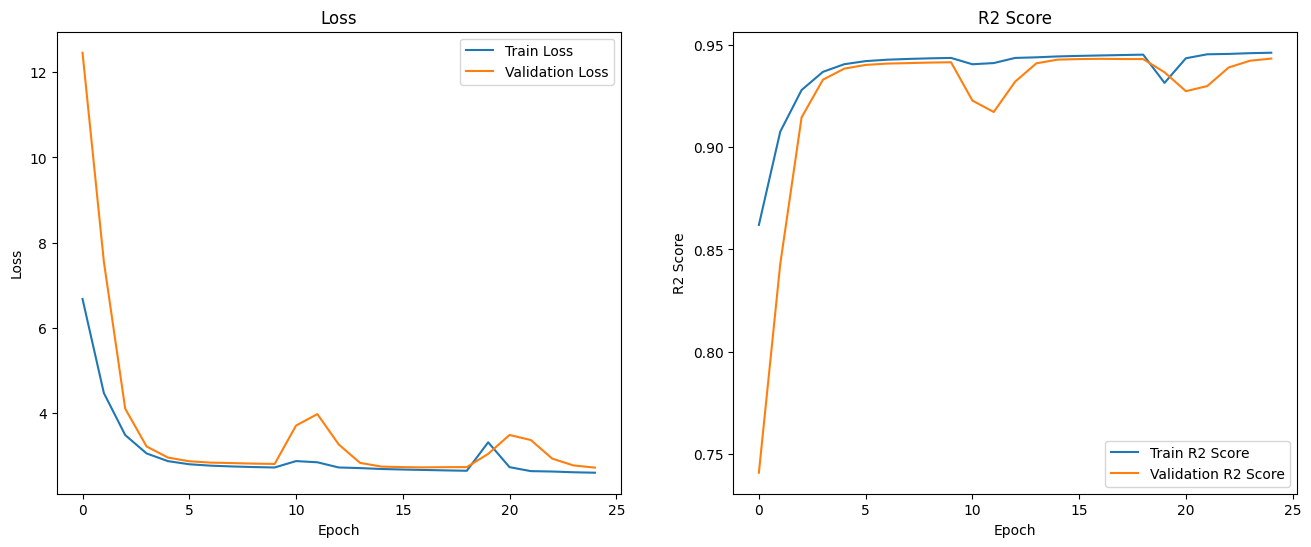

In [859]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(train_losses[-25:], label='Train Loss')
axes[0].plot(val_losses[-25:], label='Validation Loss')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(r2_trains[-25:], label='Train R2 Score')
axes[1].plot(r2_vals[-25:], label='Validation R2 Score')
axes[1].set_title('R2 Score')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('R2 Score')
axes[1].legend()

# output_path = os.path.join('images', '.png')
# plt.savefig(output_path)
# print(f'Image saved at {output_path}')

plt.show()

In [860]:
metrics = evaluate_model(model, criterion, 
                        X_train_tensor, y_train_tensor, 
                        X_val_tensor, y_val_tensor)

Train Set:
MSE: 2.689
MAE: 0.926
R2: 0.944

Validation Set:
MSE: 2.722
MAE: 0.926
R2: 0.943


In [861]:
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = preprocessor.fit_transform(X_train, y_train)
X_test = preprocessor.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [862]:
model = CustomMLP(input_dim=X_train_tensor.shape[1], output_dim=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [863]:
train_losses, test_losses, r2_trains, r2_tests = train_model(model, optimizer, criterion, 
                                                        X_train_tensor, y_train_tensor,
                                                        X_test_tensor, y_test_tensor, epochs,
                                                        t='Test')


Epoch [0/500]:	Train Loss: 4421.795	Train R2: -90.374	Test Loss: 4412.291	Test R2: -90.670

Epoch [10/500]:	Train Loss: 4367.547	Train R2: -89.253	Test Loss: 4421.263	Test R2: -90.856

Epoch [20/500]:	Train Loss: 4305.873	Train R2: -87.979	Test Loss: 4423.767	Test R2: -90.908

Epoch [30/500]:	Train Loss: 4218.297	Train R2: -86.169	Test Loss: 4365.850	Test R2: -89.705

Epoch [40/500]:	Train Loss: 4095.309	Train R2: -83.628	Test Loss: 4349.051	Test R2: -89.356

Epoch [50/500]:	Train Loss: 3932.143	Train R2: -80.256	Test Loss: 4221.916	Test R2: -86.714

Epoch [60/500]:	Train Loss: 3728.362	Train R2: -76.045	Test Loss: 4063.833	Test R2: -83.430

Epoch [70/500]:	Train Loss: 3484.532	Train R2: -71.006	Test Loss: 3789.896	Test R2: -77.739

Epoch [80/500]:	Train Loss: 3206.585	Train R2: -65.263	Test Loss: 3433.111	Test R2: -70.326

Epoch [90/500]:	Train Loss: 2900.555	Train R2: -58.939	Test Loss: 3034.408	Test R2: -62.043

Epoch [100/500]:	Train Loss: 2574.983	Train R2: -52.211	Test Loss: 264

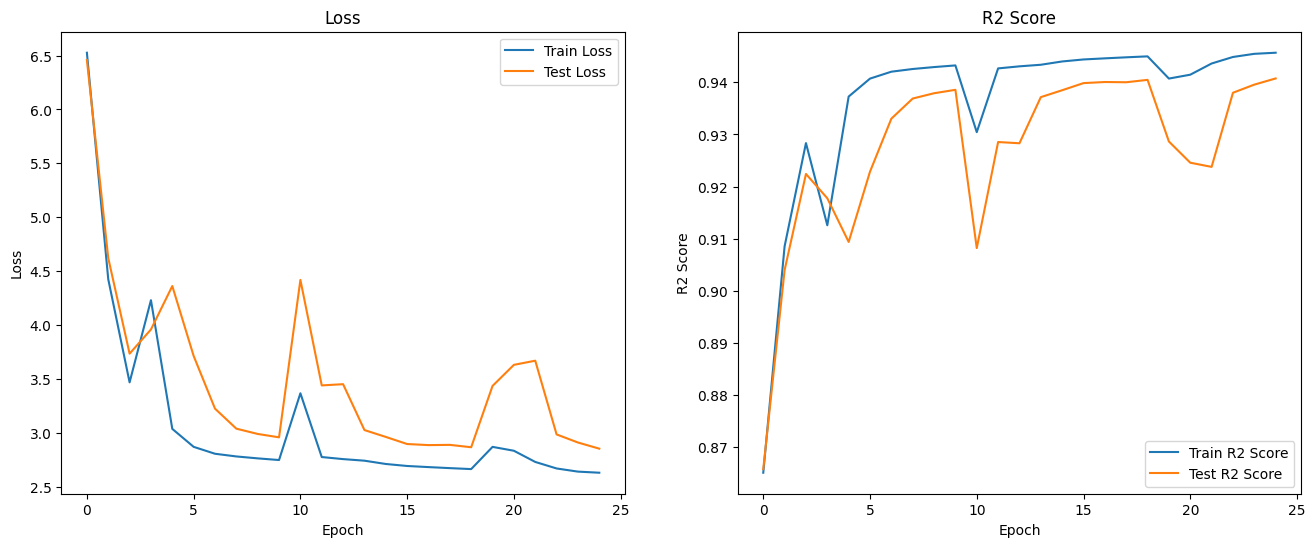

In [864]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(train_losses[-25:], label='Train Loss')
axes[0].plot(test_losses[-25:], label='Test Loss')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(r2_trains[-25:], label='Train R2 Score')
axes[1].plot(r2_tests[-25:], label='Test R2 Score')
axes[1].set_title('R2 Score')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('R2 Score')
axes[1].legend()

# output_path = os.path.join('images', '.png')
# plt.savefig(output_path)
# print(f'Image saved at {output_path}')

plt.show()

In [865]:
metrics = evaluate_model(model, criterion,
                        X_train_tensor, y_train_tensor,
                        X_test_tensor, y_test_tensor,
                        is_val=False)

Train Set:
MSE: 2.645
MAE: 0.912
R2: 0.945

Test Set:
MSE: 2.853
MAE: 0.977
R2: 0.941
